<a href="https://colab.research.google.com/github/pravin-raut/MachineLearning/blob/Master/dissertation/Currency_Forecast_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing the required libraries*

In [1]:
!pip install pmdarima
!pip install quandl
!pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 48.4 MB/s eta 0:00:00


# Importing the required packages

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime,timedelta
import json
import quandl

In [4]:
import urllib.request

file_path = "https://raw.githubusercontent.com/pravin-raut/MachineLearning/Master/dissertation/Config/Config_Git.json"

# Open the file for reading and load the data from it
with urllib.request.urlopen(file_path) as infile:
  data = json.load(infile)
# Set up API key
  api_key=data["nasdaq"]["api_key"]
quandl.ApiConfig.api_key = api_key


# Dates for which data will be extracted

In [5]:
CurrentDate = (datetime.today() - timedelta(days=0)).strftime('%Y-%m-%d')
CurrentDate
FirstDay='2019-01-01'


In [6]:

def getDataFromAPI(API,symbol,start_date,end_date):

  if API=="YFinance":
    # Create a ticker object
    ticker = yf.Ticker(symbol)
    # Download historical data
    data = ticker.history(period="1d", start=start_date, end=end_date)

  if API=="Nasdaq":
    data = quandl.get(symbol,start_date=start_date,end_date=end_date)


  return data

# Get USD to EUR  price data from YFinance

In [17]:
df_USD_EUR=getDataFromAPI("YFinance","EURUSD=X",FirstDay,CurrentDate).reset_index()
df_USD_EUR['Date'] = pd.to_datetime(df_USD_EUR['Date']).dt.date
df_USD_EUR.set_index('Date', inplace=True)
df_USD_EUR=df_USD_EUR.asfreq('b')
df_USD_EUR.Close=df_USD_EUR.Close.fillna(method='bfill')
df_USD_EUR['Original_USD_EUR_Price']=df_USD_EUR[['Close']]
df_USD_EUR=df_USD_EUR[['Original_USD_EUR_Price']]
df_USD_EUR['Original_USD_EUR_Price_MA_5'] = df_USD_EUR['Original_USD_EUR_Price'].rolling(window=5,min_periods=1).mean()
df_USD_EUR

,Original_USD_EUR_Price,Original_USD_EUR_Price_MA_5
Date,,
2019-01-01,1.149306,1.149306
2019-01-02,1.146171,1.147739
2019-01-03,1.131811,1.142429
2019-01-04,1.139108,1.141599
2019-01-07,1.141044,1.141488
...,...,...
2023-07-05,1.088495,1.089788
2023-07-06,1.085658,1.088603
2023-07-07,1.089064,1.089055


# Finding optimal values of p,d,q for ARIMA

## *   **AR term (p)**
This are lags of dependent variables. e.g. predictors for x(t) is x
(t-1) + x(t-2) + x(t-3).

## *   **Differentiation (d)**
This are number of occasions where we apply differentiation.

## *   **MA term (q)**
This are lags for errors in prediction e.g. predictor for x(t) is e(t-1) + e(t-2) + e(t-3), where e(i) is the difference between the moving average value and the actual value.




In [8]:
from statsmodels.tsa.stattools import adfuller

def perform_adfuller(series):
    # Perform Augmented Dickey-Fuller test
    result = adfuller(series)

    # Extract test statistics and p-value
    test_statistic = result[0]
    p_value = result[1]

    # Print the results
    print("Augmented Dickey-Fuller Test:")
    print(f"Test Statistic: {test_statistic}")
    print(f"P-value: {p_value}")

    # Check the p-value against a significance level (e.g., 0.05) to determine stationarity
    if p_value <= 0.05:
        print("The time series is stationary.")
    else:
        print("The time series is non-stationary.")



#Check if data is stationary by doing differnce

In [9]:
perform_adfuller(df_USD_EUR['Original_USD_EUR_Price_MA_5'].diff(1).dropna())

Augmented Dickey-Fuller Test:
Test Statistic: -6.387060446870865
P-value: 2.1512233483206395e-08
The time series is stationary.


In [11]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import matplotlib.pyplot as plt

def plot_acf_values(data, lags):
    fig, ax = plt.subplots(figsize=(12, 4))
    plot_acf(data.dropna(), lags=lags, ax=ax,zero=False)
    plt.title('ACF')
    plt.show()

def plot_pacf_values(data, lags):
    fig, ax = plt.subplots(figsize=(12, 4))
    plot_pacf(data.dropna(), lags=lags, ax=ax,zero=False,alpha=0.05)
    plt.title('PACF')
    plt.show()


# Verifying the lags which can be selected for Training the model
##The lag value where the chart crosses the confidence interval for the first time can be good starting to point to select values of P(ACF) and Q(PACF)

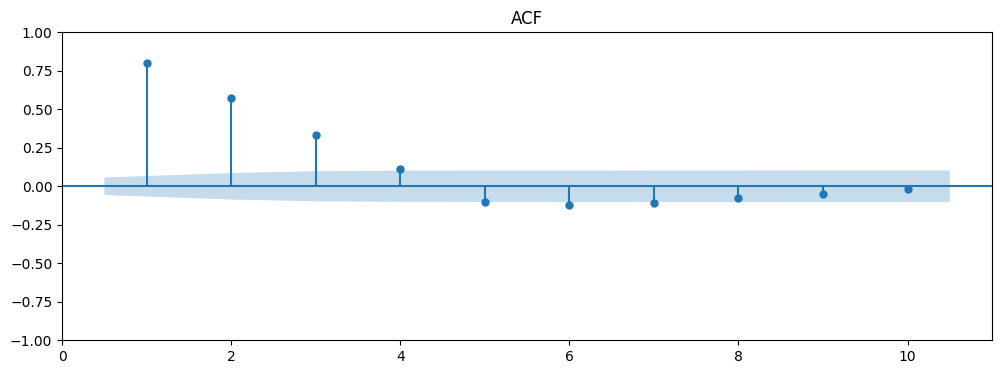

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


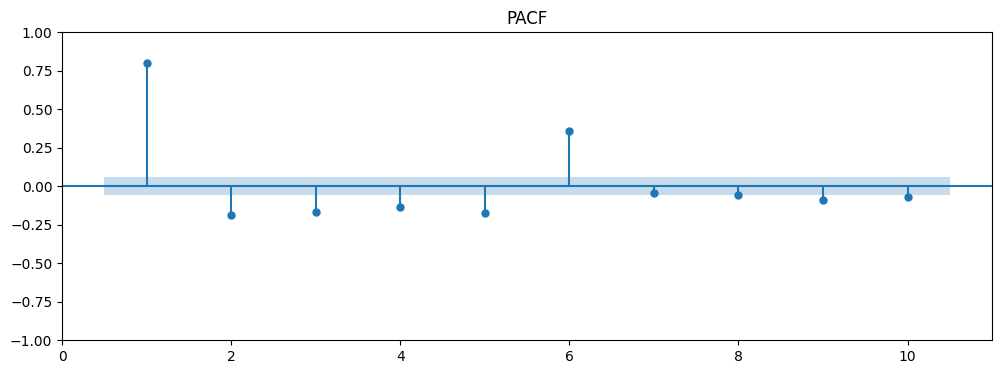

In [18]:
plot_acf_values(df_USD_EUR['Original_USD_EUR_Price_MA_5'].diff(1),10)
plot_pacf_values(df_USD_EUR['Original_USD_EUR_Price_MA_5'].diff(1),10)

# Defining Training and Testing timeline

In [77]:
# Define the start and end dates for train and test data
train_start_date = pd.to_datetime('2018-01-01')
train_end_date = pd.to_datetime('2022-12-31')
test_start_date = pd.to_datetime('2023-01-01')


In [78]:
train_data_currency = df_USD_EUR[(df_USD_EUR.index >= train_start_date) & (df_USD_EUR.index <= train_end_date)]
test_data_currency = df_USD_EUR[df_USD_EUR.index >= test_start_date]
train_data_currency.head(5)

,Original_USD_EUR_Price,Original_USD_EUR_Price_MA_5
Date,,
2019-01-01,1.149306,1.149306
2019-01-02,1.146171,1.147739
2019-01-03,1.131811,1.142429
2019-01-04,1.139108,1.141599
2019-01-07,1.141044,1.141488


# Auto Arima to find values of p,d,q

In [79]:
from pmdarima import auto_arima
model = auto_arima(train_data_currency['Original_USD_EUR_Price'].dropna(),
                   start_p=1, start_q=1,d=2,
                         seasonal=False,   # No Seasonality
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)
model.summary()


Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=-7923.694, Time=0.53 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-7420.323, Time=0.21 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-7689.816, Time=0.18 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=-7914.745, Time=0.73 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-7422.321, Time=0.18 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=-7994.935, Time=1.40 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=-7782.531, Time=0.60 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=-7884.843, Time=1.09 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=-7964.037, Time=1.16 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=-7956.236, Time=0.64 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=-7846.052, Time=0.46 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=-7956.688, Time=1.20 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=0.89 sec

Best model:  ARIMA(2,2,1)(0,0,0)[0] intercept
Total fit time: 9.295 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1044
Model:               SARIMAX(2, 2, 1)   Log Likelihood                4002.467
Date:                Wed, 12 Jul 2023   AIC                          -7994.935
Time:                        03:09:42   BIC                          -7970.190
Sample:                    01-01-2019   HQIC                         -7985.549
                         - 12-30-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -3.231e-06   2.48e-05     -0.130      0.896   -5.19e-05    4.54e-05
ar.L1         -0.0283      0.032     -0.896      0.370      -0.090       0.034
ar.L2         -0.0434      0.032     -1.353      0.176      -0.106       0.019
ma.L1         -0.8488      0.022    -39.185      0.000      -0.891      -0.806
sigma2      2.691e-05   9.21e-07     29.217      0.000    2.51e-05    2.87e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):                97.64
Prob(Q):                              0.73   Prob(JB):                         0.00
Heteroskedasticity (H):               1.71   Skew:                            -0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [80]:
import warnings
warnings.filterwarnings("ignore")


After verifying manually diffrent values , along with what was observed from plot_acf and plot_pacf decided values of p,d,q

In [81]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

cur_model=SARIMAX(train_data_currency['Original_USD_EUR_Price_MA_5'],order=(6,1,6))
cur_model_fit=cur_model.fit(maxiter=1000)
cur_model_fit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                    
=======================================================================================
Dep. Variable:     Original_USD_EUR_Price_MA_5   No. Observations:                 1044
Model:                        SARIMAX(6, 1, 6)   Log Likelihood                5654.706
Date:                         Wed, 12 Jul 2023   AIC                         -11283.413
Time:                                 03:09:46   BIC                         -11219.065
Sample:                             01-01-2019   HQIC                        -11259.006
                                  - 12-30-2022                                         
Covariance Type:                           opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1703      0.477      2.456      0.014       0.236       2.104
ar.L2         -0.4902      0.507     -0.968      0.333      -1.483       0.503
ar.L3         -0.0119      0.109     -0.110      0.913      -0.225       0.201
ar.L4          0.0306      0.078      0.392      0.695      -0.123       0.184
ar.L5          0.0518      0.077      0.673      0.501      -0.099       0.203
ar.L6         -0.0785      0.044     -1.772      0.076      -0.165       0.008
ma.L1         -0.1674      0.475     -0.352      0.725      -1.099       0.764
ma.L2          0.2779      0.152      1.828      0.067      -0.020       0.576
ma.L3          0.2516      0.145      1.740      0.082      -0.032       0.535
ma.L4          0.2221      0.138      1.605      0.109      -0.049       0.493
ma.L5         -0.5526      0.125     -4.424      0.000      -0.797      -0.308
ma.L6          0.2404      0.322      0.747      0.455      -0.390       0.871
sigma2      1.133e-06   4.14e-08     27.386      0.000    1.05e-06    1.21e-06
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               240.81
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               1.74   Skew:                            -0.07
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.2e+14. Standard errors may be unstable.
"""

#Things to verifiy in optimal model selection
### 1) Log Likelihood ==> Higher the log value better the model is performing.
### 2) AIC , BIC, HQIC --> This are information criteria whcih states lower the criteria better is the model.

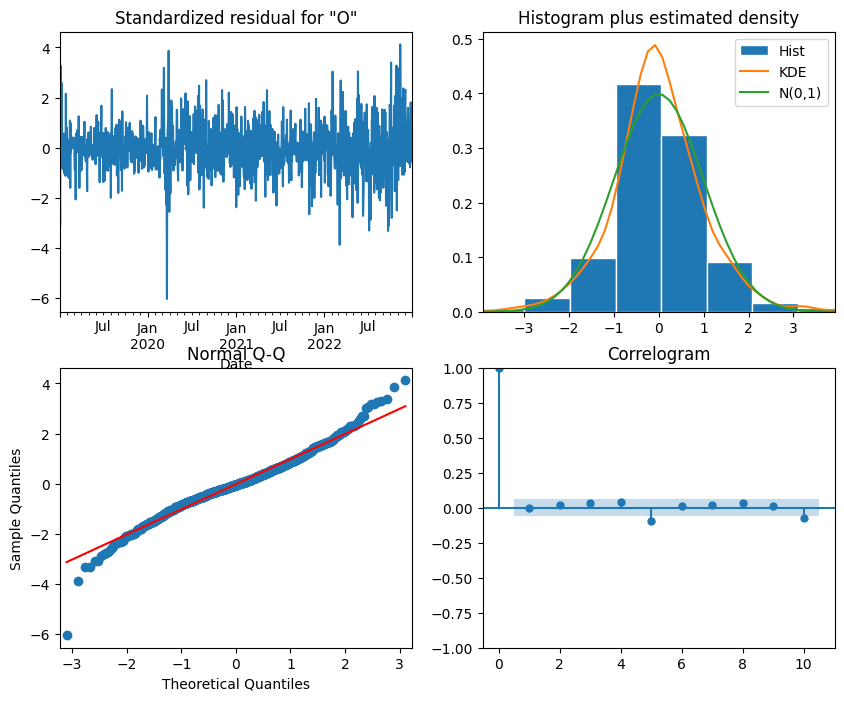

In [82]:
cur_model_fit.plot_diagnostics(figsize=(10,8))
plt.show()


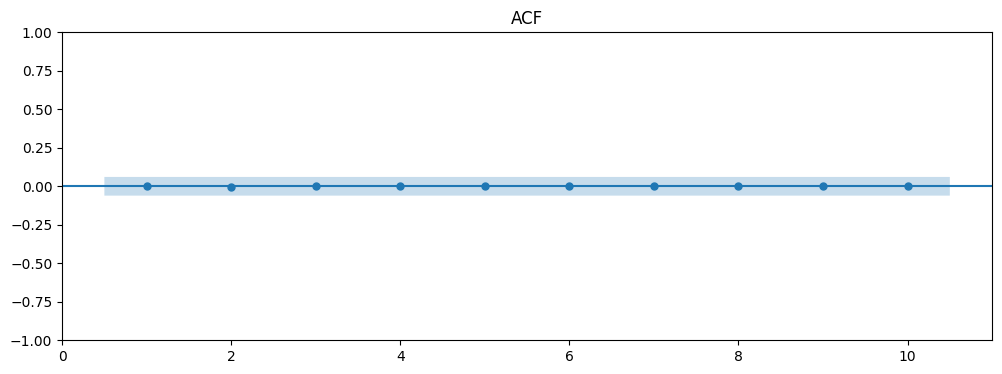

In [83]:
reid=cur_model_fit.resid
plot_acf_values(reid,10)


### **1. Standardized Residulal** : This residual doesnt show any pattern and are randomly distributed around zero.
### **2. Histogram Plust esitmeted density** : Residuals are normally distriuted
### **3. Normal Q-Q Plot** : Most of the are along red line
### **4. Correlogram** : Its and ACF plot of residuals at diffrent lag and their is no autocorrelation seen

In [84]:
# Get in-sample predictions
training_data_predictions = cur_model_fit.get_prediction(start=train_data_currency.dropna().index.min(),
                                                      end=train_data_currency.dropna().index.max(),
                                                      dynamic=False)

train_data_currency[['lower Cur predictions','Higher Oil predictions']] = training_data_predictions.conf_int()

# Create a new column for the predicted values
train_data_currency['Cur predictions'] = training_data_predictions.predicted_mean

train_data_currency

,Original_USD_EUR_Price,Original_USD_EUR_Price_MA_5,lower Cur predictions,Higher Oil predictions,Cur predictions
Date,,,,,
2019-01-01,1.149306,1.149306,-1959.963985,1959.963985,0.000000
2019-01-02,1.146171,1.147739,1.144913,1.153699,1.149306
2019-01-03,1.131811,1.142429,1.143912,1.149014,1.146463
2019-01-04,1.139108,1.141599,1.134970,1.139924,1.137447
2019-01-07,1.141044,1.141488,1.138935,1.143804,1.141370
...,...,...,...,...,...
2022-12-26,1.066780,1.062456,1.058447,1.062622,1.060535
2022-12-27,1.064022,1.062969,1.061474,1.065649,1.063562
2022-12-28,1.063717,1.063172,1.061418,1.065592,1.063505


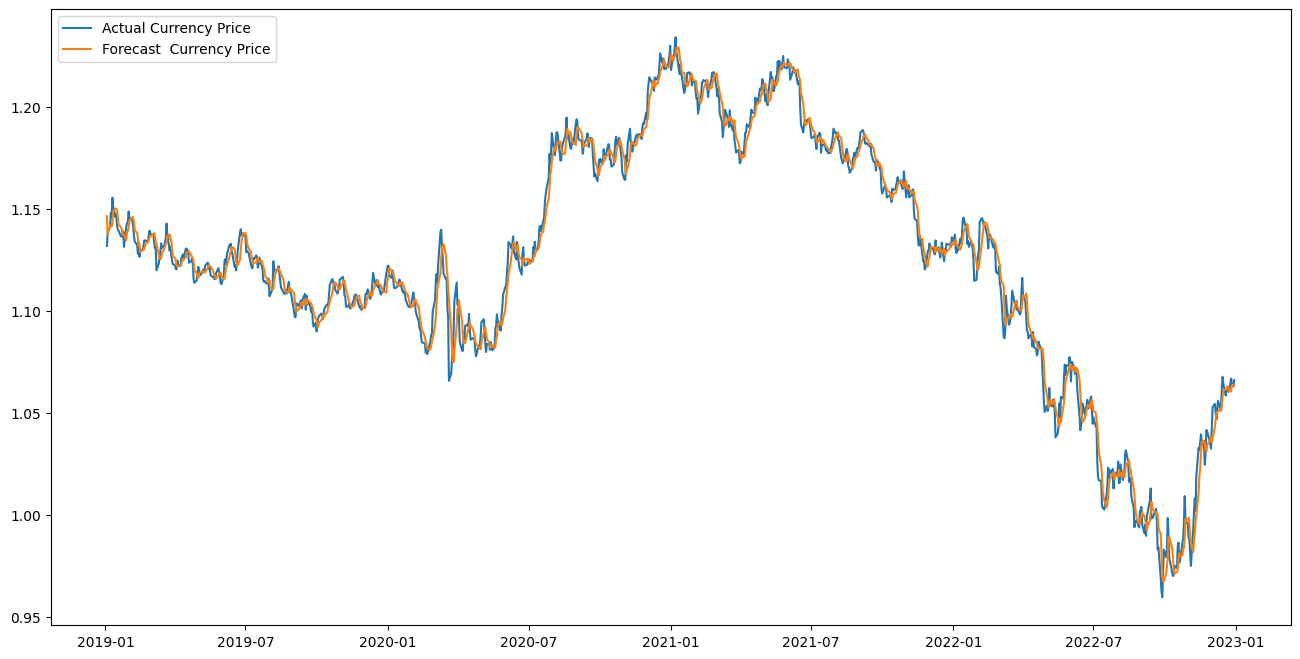

In [85]:
plt.figure(figsize=(16,8))
plt.plot(train_data_currency['Original_USD_EUR_Price'][2:],label="Actual Currency Price")
plt.plot(train_data_currency['Cur predictions'][2:],label="Forecast  Currency Price")
plt.legend(loc="upper left")

# Testing Started

# One Day Steap Ahead -Walk-Forward Validation



In [86]:


# define model configuration
my_order = (6,1,6)

# lists to collect forecasts
forecasts = []

# walk-forward validation
history = [x for x in train_data_currency['Original_USD_EUR_Price_MA_5']]
for i in range(len(test_data_currency['Original_USD_EUR_Price_MA_5'])):
    if i % 5==0:
      #auto = auto_arima(history, error_action='ignore', suppress_warnings=True,d=2)
      #my_order = auto.order
      model = SARIMAX(history, order=my_order)
      model_fit = model.fit(maxiter=1000)
    forecast = model_fit.get_forecast(steps=1, alpha=0.05)
    forecasts.append(forecast.predicted_mean[0])
    history.append(test_data_currency['Original_USD_EUR_Price'][i])
    print("my_order is {} for date {} and predicted value is {} and actual value is {} ".format(my_order,test_data_currency['Original_USD_EUR_Price_MA_5'].index[i],forecast.predicted_mean[0],test_data_currency['Original_USD_EUR_Price_MA_5'][test_data_currency['Original_USD_EUR_Price_MA_5'].index[i]]))
# Create a dataframe to hold the forecasts with corresponding dates
forecast_df = pd.DataFrame(data={'Forecast': forecasts}, index=test_data_currency['Original_USD_EUR_Price'].index)



my_order is (6, 1, 6) for date 2023-01-02 00:00:00 and predicted value is 1.064581335878041 and actual value is 1.0655425310134887 
my_order is (6, 1, 6) for date 2023-01-03 00:00:00 and predicted value is 1.064581335878041 and actual value is 1.0662923812866212 
my_order is (6, 1, 6) for date 2023-01-04 00:00:00 and predicted value is 1.064581335878041 and actual value is 1.0644861459732056 
my_order is (6, 1, 6) for date 2023-01-05 00:00:00 and predicted value is 1.064581335878041 and actual value is 1.0640284299850464 
my_order is (6, 1, 6) for date 2023-01-06 00:00:00 and predicted value is 1.064581335878041 and actual value is 1.0612577199935913 
my_order is (6, 1, 6) for date 2023-01-09 00:00:00 and predicted value is 1.0395795650655872 and actual value is 1.0601895093917846 
my_order is (6, 1, 6) for date 2023-01-10 00:00:00 and predicted value is 1.0395795650655872 and actual value is 1.0612988948822022 
my_order is (6, 1, 6) for date 2023-01-11 00:00:00 and predicted value is 

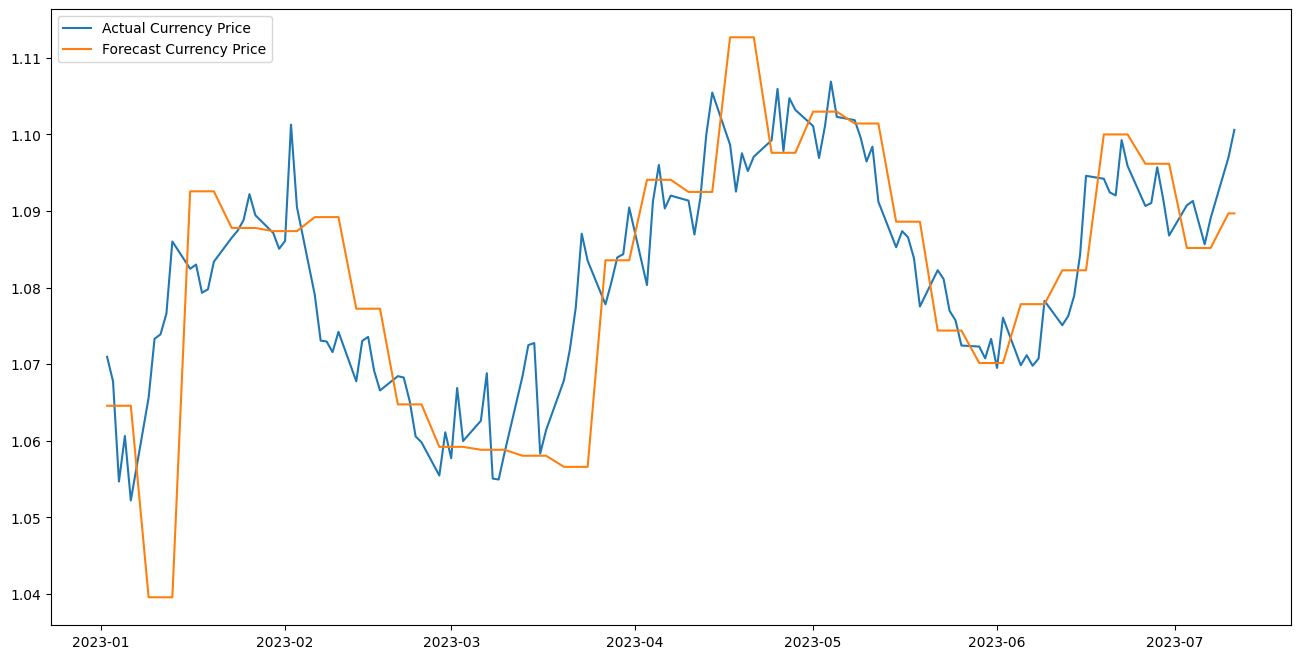

In [87]:
plt.figure(figsize=(16,8))
plt.plot(test_data_currency['Original_USD_EUR_Price'],label="Actual Currency Price")
plt.plot(forecast_df['Forecast'],label="Forecast Currency Price")

plt.legend(loc="upper left")
plt.show()


In [88]:

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return {"Mean Absolute Error": mae, "Mean Squared Error": mse, "Root Mean Squared Error": rmse, "Mean Absolute Percentage Error": mape}



# Calcualate metrics of model for One Day Forecasting

In [89]:

metrics = calculate_metrics(test_data_currency['Original_USD_EUR_Price'].dropna(), forecast_df['Forecast'].dropna())
metrics

{'Mean Absolute Error': 0.007483308877211633,
 'Mean Squared Error': 0.0001178457763199907,
 'Root Mean Squared Error': 0.010855679449946498,
 'Mean Absolute Percentage Error': 0.6923463425939917}

# Five Day Steap Ahead -Walk-Forward Validation



In [90]:
# define model configuration
my_order = (6,1,6)

# lists to collect forecasts
forecasts = []
#forecast_dates = []

# walk-forward validation
history = [x for x in train_data_currency['Original_USD_EUR_Price_MA_5']]
for i in range(0,len(test_data_currency['Original_USD_EUR_Price_MA_5']),5):
    if i % 5==0:
      #auto = auto_arima(history, error_action='ignore', suppress_warnings=True,d=2)
      #my_order = auto.order
      model = SARIMAX(history, order=my_order)
      model_fit = model.fit(maxiter=1000)

    # if less than 5 steps remaining, adjust steps to fit
    steps = min(5, len(test_data_currency['Original_USD_EUR_Price_MA_5']) - i)
    forecast = model_fit.get_forecast(steps=steps, alpha=0.05)
    forecasts.extend(forecast.predicted_mean)  # using extend instead of append
    #forecast_dates.extend(test_data_currency['Original_USD_EUR_Price'].index[i:i+steps])  # storing dates for all 5 days

    # Append all forecasted values to the history
    history.extend(test_data_currency['Original_USD_EUR_Price'][i:i+steps])
    print("my_order is {} for Week Starting {} and predicted value is {} and actual value is {}".format(my_order,test_data_currency['Original_USD_EUR_Price_MA_5'].index[i],test_data_currency['Original_USD_EUR_Price_MA_5'][i:i+steps],test_data_currency['Original_USD_EUR_Price_MA_5'][test_data_currency['Original_USD_EUR_Price_MA_5'].index[i:i+steps]].values.tolist()))
# Create a dataframe to hold the forecasts with corresponding dates
forecast_df = pd.DataFrame(data={'Forecast': forecasts}, index=test_data_currency['Original_USD_EUR_Price'].index)



my_order is (6, 1, 6) for Week Starting 2023-01-02 00:00:00 and predicted value is Date
2023-01-02    1.065543
2023-01-03    1.066292
2023-01-04    1.064486
2023-01-05    1.064028
2023-01-06    1.061258
Freq: B, Name: Original_USD_EUR_Price_MA_5, dtype: float64 and actual value is [1.0655425310134887, 1.0662923812866212, 1.0644861459732056, 1.0640284299850464, 1.0612577199935913]
my_order is (6, 1, 6) for Week Starting 2023-01-09 00:00:00 and predicted value is Date
2023-01-09    1.060190
2023-01-10    1.061299
2023-01-11    1.065141
2023-01-12    1.068333
2023-01-13    1.075094
Freq: B, Name: Original_USD_EUR_Price_MA_5, dtype: float64 and actual value is [1.0601895093917846, 1.0612988948822022, 1.065140724182129, 1.0683334350585938, 1.0750938653945923]
my_order is (6, 1, 6) for Week Starting 2023-01-16 00:00:00 and predicted value is Date
2023-01-16    1.078460
2023-01-17    1.080399
2023-01-18    1.081486
2023-01-19    1.082123
2023-01-20    1.081596
Freq: B, Name: Original_USD_EUR_

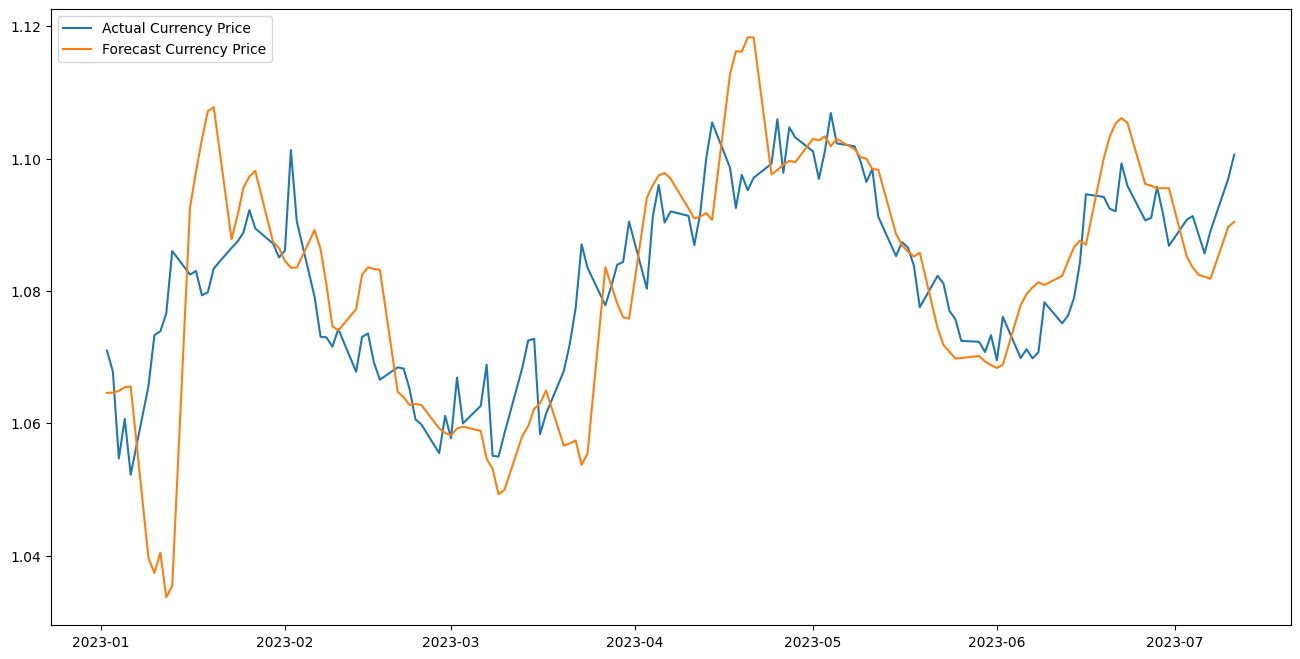

In [91]:
plt.figure(figsize=(16,8))
plt.plot(test_data_currency['Original_USD_EUR_Price'],label="Actual Currency Price")
plt.plot(forecast_df['Forecast'],label="Forecast Currency Price")

plt.legend(loc="upper left")
plt.show()


# Calcualate metrics of model for Five Day Forecasting

In [92]:

metrics = calculate_metrics(test_data_currency['Original_USD_EUR_Price'].dropna(), forecast_df['Forecast'].dropna())
metrics

{'Mean Absolute Error': 0.008661708562673431,
 'Mean Squared Error': 0.0001494867690234381,
 'Root Mean Squared Error': 0.012226478193798821,
 'Mean Absolute Percentage Error': 0.8010767070985192}

In [93]:


# define model configuration
my_order = (6,1,6)

# lists to collect forecasts
forecasts = []

# walk-forward validation
history = [x for x in train_data_currency['Original_USD_EUR_Price_MA_5']]
for i in range(len(test_data_currency['Original_USD_EUR_Price_MA_5'])):
    if i % 5==0:
      #auto = auto_arima(history, error_action='ignore', suppress_warnings=True,d=2)
      #my_order = auto.order
      model = SARIMAX(history, order=my_order)
      model_fit = model.fit(maxiter=1000)
    forecast = model_fit.get_forecast(steps=1, alpha=0.05)
    forecasts.append(forecast.predicted_mean[0])
    history.append(forecast.predicted_mean[0])
    print("my_order is {} for date {} and predicted value is {} and actual value is {} ".format(my_order,test_data_currency['Original_USD_EUR_Price_MA_5'].index[i],forecast.predicted_mean[0],test_data_currency['Original_USD_EUR_Price_MA_5'][test_data_currency['Original_USD_EUR_Price_MA_5'].index[i]]))
# Create a dataframe to hold the forecasts with corresponding dates
forecast_df = pd.DataFrame(data={'Forecast': forecasts}, index=test_data_currency['Original_USD_EUR_Price'].index)



my_order is (6, 1, 6) for date 2023-01-02 00:00:00 and predicted value is 1.064581335878041 and actual value is 1.0655425310134887 
my_order is (6, 1, 6) for date 2023-01-03 00:00:00 and predicted value is 1.064581335878041 and actual value is 1.0662923812866212 
my_order is (6, 1, 6) for date 2023-01-04 00:00:00 and predicted value is 1.064581335878041 and actual value is 1.0644861459732056 
my_order is (6, 1, 6) for date 2023-01-05 00:00:00 and predicted value is 1.064581335878041 and actual value is 1.0640284299850464 
my_order is (6, 1, 6) for date 2023-01-06 00:00:00 and predicted value is 1.064581335878041 and actual value is 1.0612577199935913 
my_order is (6, 1, 6) for date 2023-01-09 00:00:00 and predicted value is 1.0644331206476287 and actual value is 1.0601895093917846 
my_order is (6, 1, 6) for date 2023-01-10 00:00:00 and predicted value is 1.0644331206476287 and actual value is 1.0612988948822022 
my_order is (6, 1, 6) for date 2023-01-11 00:00:00 and predicted value is 

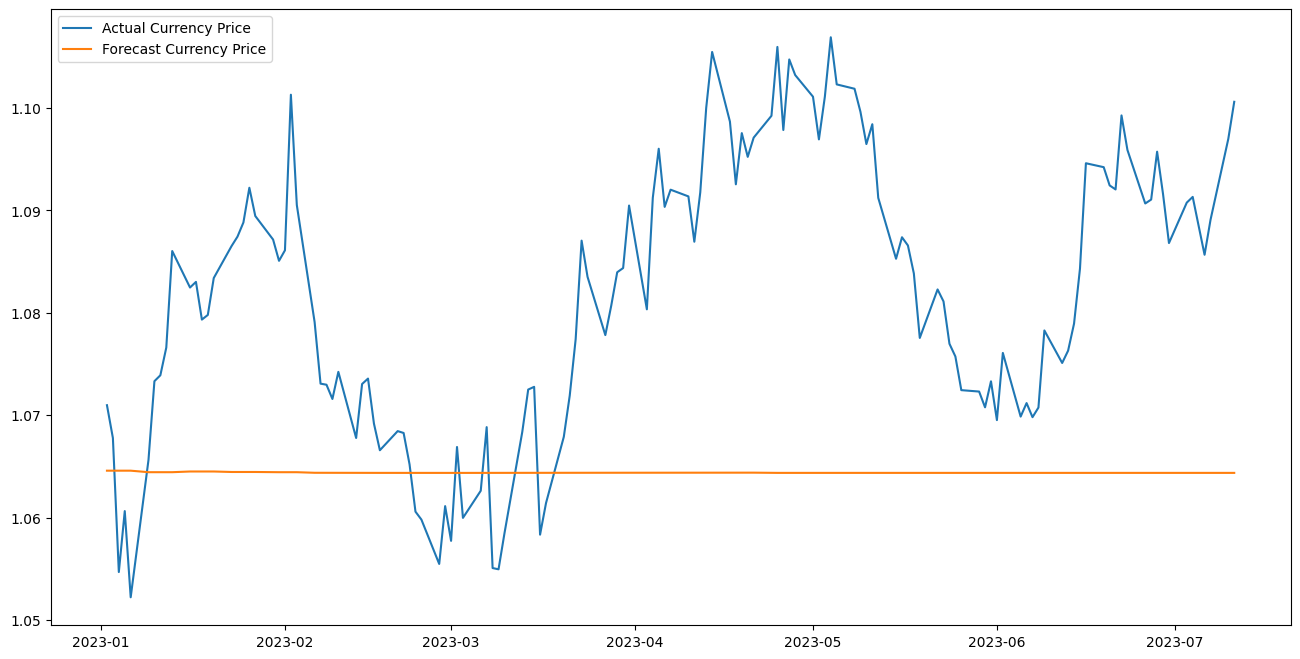

In [94]:
plt.figure(figsize=(16,8))
plt.plot(test_data_currency['Original_USD_EUR_Price'],label="Actual Currency Price")
plt.plot(forecast_df['Forecast'],label="Forecast Currency Price")

plt.legend(loc="upper left")
plt.show()


In [95]:

metrics = calculate_metrics(test_data_currency['Original_USD_EUR_Price'].dropna(), forecast_df['Forecast'].dropna())
metrics

{'Mean Absolute Error': 0.01866989814190015,
 'Mean Squared Error': 0.0004802740538985813,
 'Root Mean Squared Error': 0.021915155803657462,
 'Mean Absolute Percentage Error': 1.7137213321894127}

In [96]:
testing_data_forecast = cur_model_fit.get_forecast(steps=len(test_data_currency), alpha=0.05)


# Create a new dataframe to hold the forecast
test_data_currency[['lower Cur predictions','Higher Cur predictions']] = testing_data_forecast.conf_int()

# Create a new column for the forecasted values
test_data_currency['Cur predictions'] =  testing_data_forecast.predicted_mean


test_data_currency

,Original_USD_EUR_Price,Original_USD_EUR_Price_MA_5,lower Cur predictions,Higher Cur predictions,Cur predictions
Date,,,,,
2023-01-02,1.070973,1.065543,1.062494,1.066669,1.064581
2023-01-03,1.067771,1.066292,1.059952,1.069299,1.064626
2023-01-04,1.054685,1.064486,1.057120,1.072628,1.064874
2023-01-05,1.060637,1.064028,1.054313,1.076605,1.065459
2023-01-06,1.052222,1.061258,1.050785,1.080279,1.065532
...,...,...,...,...,...
2023-07-05,1.088495,1.089788,0.971959,1.158244,1.065101
2023-07-06,1.085658,1.088603,0.971608,1.158595,1.065101
2023-07-07,1.089064,1.089055,0.971258,1.158944,1.065101


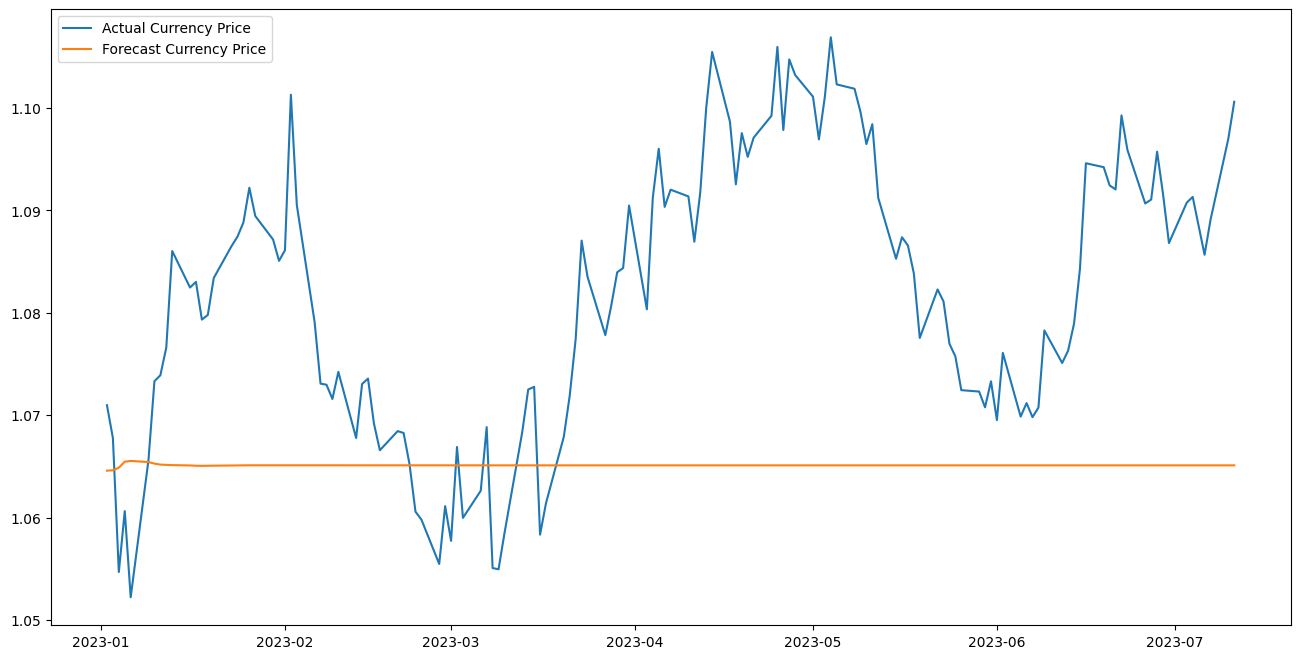

In [99]:
plt.figure(figsize=(16,8))
plt.plot(test_data_currency['Original_USD_EUR_Price'],label="Actual Currency Price")
plt.plot(test_data_currency['Cur predictions'],label="Forecast Currency Price")

plt.legend(loc="upper left")
plt.show()


In [100]:

metrics = calculate_metrics(test_data_currency['Original_USD_EUR_Price'], test_data_currency['Cur predictions'])
metrics

{'Mean Absolute Error': 0.01811830258451664,
 'Mean Squared Error': 0.00045606667681031914,
 'Root Mean Squared Error': 0.021355717660858864,
 'Mean Absolute Percentage Error': 1.6630487752895586}

In [102]:

metrics = calculate_metrics(test_data_currency['Original_USD_EUR_Price'][:10], test_data_currency['Cur predictions'][:10])
metrics

{'Mean Absolute Error': 0.008718905168699286,
 'Mean Squared Error': 0.00010637922084875758,
 'Root Mean Squared Error': 0.01031403029124685,
 'Mean Absolute Percentage Error': 0.8146820301287352}

In [103]:

metrics = calculate_metrics(test_data_currency['Original_USD_EUR_Price'][:15], test_data_currency['Cur predictions'][:15])
metrics

{'Mean Absolute Error': 0.01132144835668057,
 'Mean Squared Error': 0.00016291083355258603,
 'Root Mean Squared Error': 0.012763652829522826,
 'Mean Absolute Percentage Error': 1.0523666432039749}

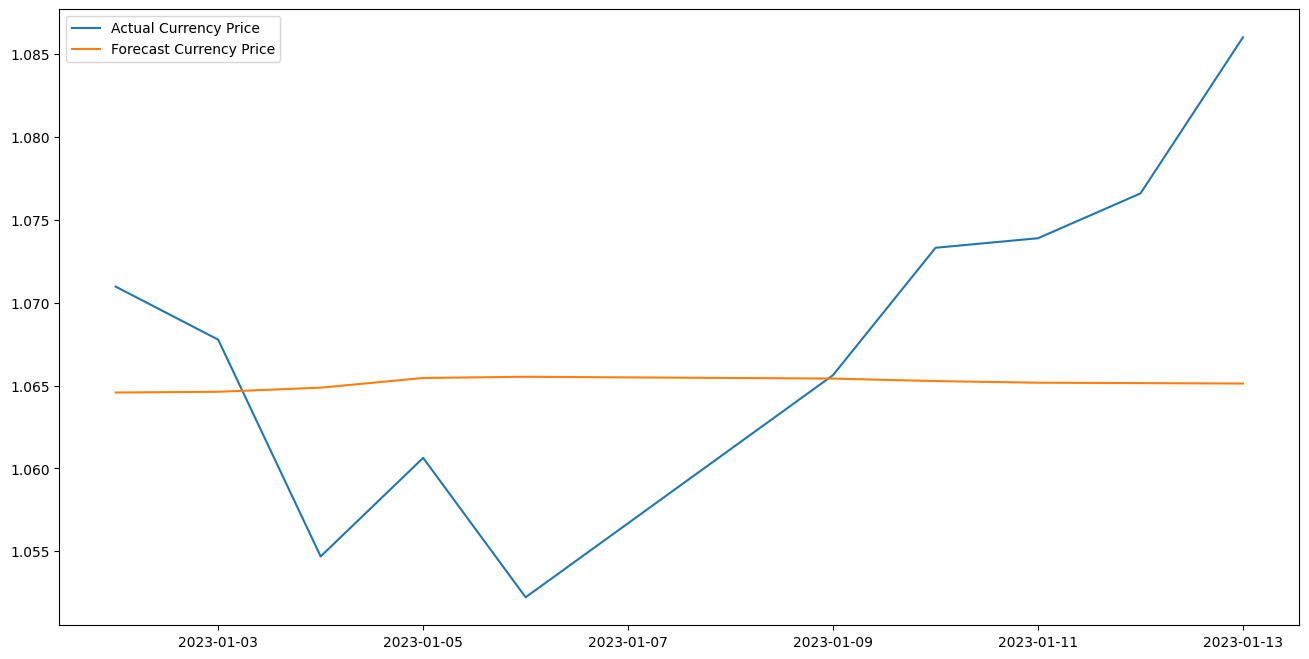

In [101]:
plt.figure(figsize=(16,8))
plt.plot(test_data_currency['Original_USD_EUR_Price'],label="Actual Currency Price")
plt.plot(test_data_currency['Cur predictions'],label="Forecast Currency Price")

plt.legend(loc="upper left")
plt.show()
